In [9]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [22]:
"""
YOU WILL HAVE TO CHANGE THE FILE PATH TO WORK ON THE FILE SO ON EACH COMPUTER, AS THIS IS TO FOR MY COMPUTER.

"""

'\nYOU WILL HAVE TO CHANGE THE FILE PATH TO WORK ON THE FILE SO ON EACH COMPUTER, AS THIS IS TO FOR MY COMPUTER.\n\n'

In [7]:
#What are the changes in air travel behaviour of passengers per month before covid 
# and after covid in terms of prefered destinations both for short- and long-haul destinations?
# Define the file path
file_path = 'Downloads\dataset_full.csv'

#filter the data per month + prefered destinations

# Read the CSV file
df_raw = pd.read_csv(file_path, delimiter=";")

"""
Leaving some information for the rest of the project:
The data is structured so that:

Technically you can use the Periods with their code as key: 2015MM01 and 
use the Month/Year columns for the output parts and visualisation. on the X-axis for example. 

another thing for the data
    -> Each quarter already has sum over the values for the months during the quarter 
        -> i.e Q1 values = Sum(Januar,feb,March)
    -> same goes for the years, as they have summed over the quarters or months (which gives the same results)

if you want to do some quarterly values

On the other hand, you have for example:
    -> Total passengers = sheduled + Non_sheduled
        -> As well as Total passengers = Arriving + Departuring 
    -> Asia = West_Asia + East_asia + North_Asia + South_Asia

So you have a lot of breakdown and you can simply pick the columns you want to compare. 

NEWS = North + East + West + South (funny fact newspaper can be interpreted as north/east/west/south/past/and/present/event report )

For europe you only have EU and Non-Eu countries data. Why noth broken into regions idk. 
(Let's just say Europe is one big family in small island in the report, just how we can treat US as a whole)
"""

def preprocessing(df):

    #Filter data, so that we work only with Passengers and only for years above 2015(excluding) 2020
    df = df.iloc[:, :43]
    df = df[ (df['Periods'].str[:4].astype(int) >= 2015) & (df['Periods'].str[:4].astype(int) != 2020)] #add only dates post 2015

    # Function to extract year, month, and quarter from the Periods column
    def extract_date(period):
        #the function returns year, Month, Quarter and since we 
        #have either Month or Quarter, the missing one is set as None

        year = period[:4]               # Extract the year
        if 'MM' in period:
            month = str(period[6:])     # Extract month number for MM format
            return year, month, None    
        elif 'KW' in period:
            quarter = str(period[6:])   # Extract quarter number for KW format
            return year, None, quarter  
        return year, None, None  

    # Create new columns for Year, Month, and Quarter
    df[['Year', 'Month_Num', 'Quarter_Num']] = df['Periods'].apply(extract_date).apply(pd.Series)

    # Map months to month names
    month_names = {
        '01': 'January', '02': 'February', '03': 'March', '04': 'April', 
        '05': 'May', '06': 'June', '07': 'July', '08': 'August', 
        '09': 'September', '10': 'October', '11': 'November', '12': 'December'
    }

    # Map quarters to quarter names
    quarter_names = {
        '01': 'Q1', '02': 'Q2', '03': 'Q3', '04': 'Q4'
    }

    #Map airports to their airport quarter  
    airport_names = {
        'A043590':'Amsterdam Schiphol', 'A043596':'Rotterdam','A043591':'Eindhoven'
    }

    # Further data processing 
    df['Month'] = df['Month_Num'].map(month_names)
    df['Quarter'] = df['Quarter_Num'].map(quarter_names)
    df['Airport'] = df['Airports'].map(airport_names)

    # fill in the missing data in the column "month" with the Quarter or year 
    df['Month'] = df['Month'].fillna(df['Quarter'])             
    df['Month'] = df['Month'].fillna(df['Year']) 

    df = df.drop('Quarter', axis=1)         #Quarter is no longer needed 
    # Drop the Month_Num and Quarter_Num columns as they are not needed anymore 
    df.drop(columns=['Month_Num', 'Quarter_Num'], inplace=True)
    df.drop(columns=['Airports'], inplace=True)

    #Local flights are not revelant for this project 
    df.drop(columns=['LocalFlights_2'], inplace=True)

    # List of columns to move and the column after which to insert them
    cols_to_move = ['Month', 'Year', 'Airport']
    insert_after = 'Periods'

    # Get the current columns and find the index of 'Period'
    cols = list(df.columns)
    insert_at = cols.index(insert_after) + 1

    # Remove the columns to move from their original positions
    for col in cols_to_move:
        cols.remove(col)

    # Insert the columns after 'Period'
    for i, col in enumerate(cols_to_move):
        cols.insert(insert_at + i, col)

    # Reorder the DataFrame
    df = df[cols]

    return df

df_processesd = preprocessing(df_raw)

# Display the updated DataFrame
print(df_processesd.head(20))
print(df_processesd.count())

      ID   Periods      Month  Year             Airport  \
274  711  2015MM01    January  2015  Amsterdam Schiphol   
275  712  2015MM02   February  2015  Amsterdam Schiphol   
276  713  2015MM03      March  2015  Amsterdam Schiphol   
277  714  2015KW01         Q1  2015  Amsterdam Schiphol   
278  715  2015MM04      April  2015  Amsterdam Schiphol   
279  716  2015MM05        May  2015  Amsterdam Schiphol   
280  717  2015MM06       June  2015  Amsterdam Schiphol   
281  718  2015KW02         Q2  2015  Amsterdam Schiphol   
282  719  2015MM07       July  2015  Amsterdam Schiphol   
283  720  2015MM08     August  2015  Amsterdam Schiphol   
284  721  2015MM09  September  2015  Amsterdam Schiphol   
285  722  2015KW03         Q3  2015  Amsterdam Schiphol   
286  723  2015MM10    October  2015  Amsterdam Schiphol   
287  724  2015MM11   November  2015  Amsterdam Schiphol   
288  725  2015MM12   December  2015  Amsterdam Schiphol   
289  726  2015KW04         Q4  2015  Amsterdam Schiphol 

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
C:\Users\949847\AppData\Local\Temp\ipykernel_17660\2971596295.py:4: SyntaxWarning: invalid escape sequence '\d'
  file_path = 'Downloads\dataset_full.csv'


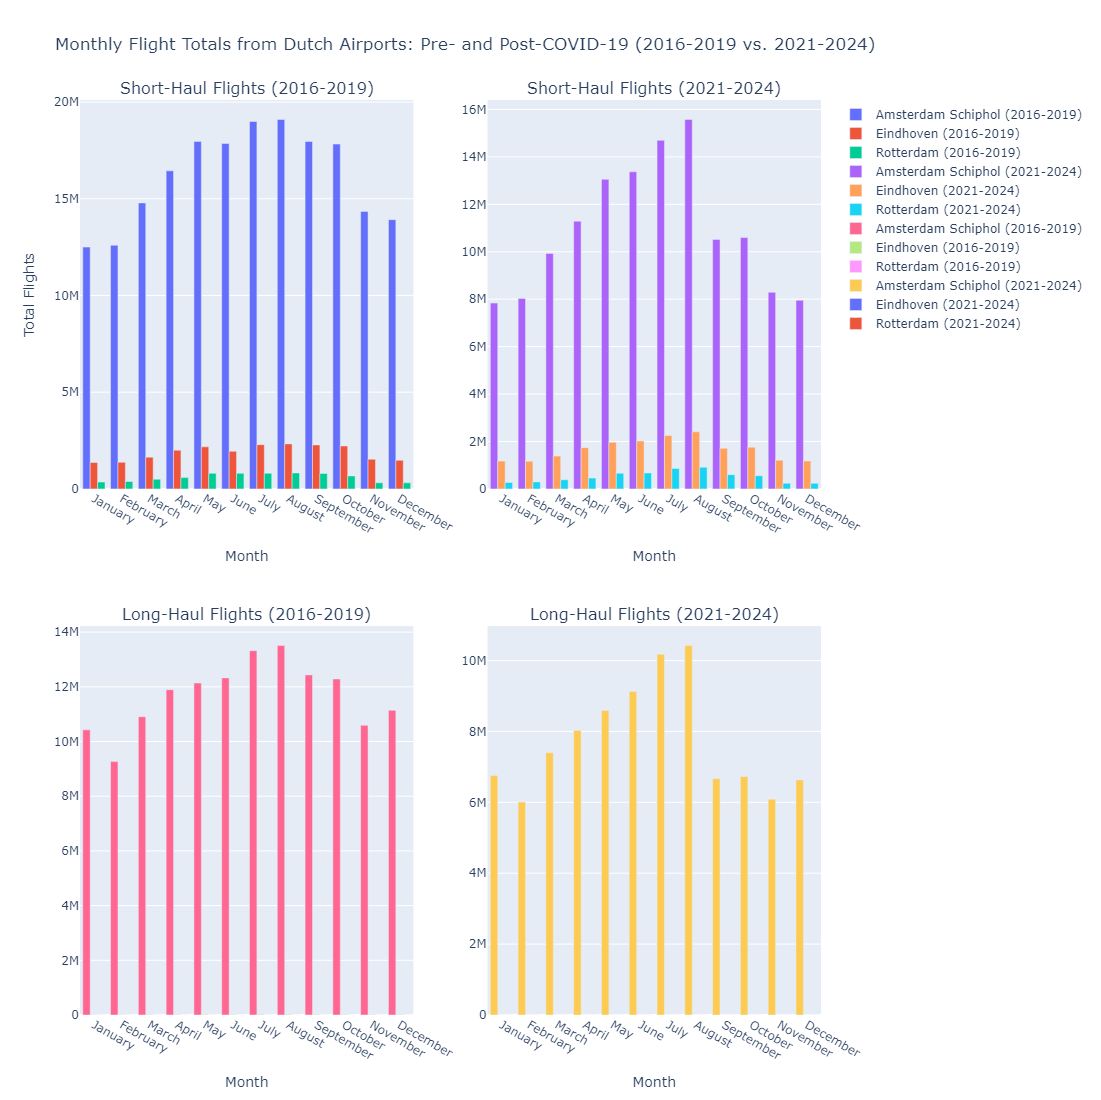

In [69]:
def total_flights_short_long_haul_combined(df):
    airports = ["Amsterdam Schiphol", "Eindhoven", "Rotterdam"]
    short_haul = ['EUCountries_23', 'OtherEurope_24']
    long_haul = [
        'SouthAfrica_31', 'America_32', 'NorthAmerica_33', 'CentralAmerica_34',
        'SouthAmerica_35', 'Asia_36', 'WestAsia_37', 'SouthEastAsia_38', 
        'NorthEastAsia_39', 'Oceania_40'
    ]

    # Convert Year to integer to avoid type issues
    df["Year"] = pd.to_numeric(df["Year"], errors="coerce")

    df_filtered = df.loc[
        (df["Airport"].isin(airports)) &
        (df["Month"].isin([
            "January", "February", "March", "April", "May", "June", 
            "July", "August", "September", "October", "November", "December"
        ])) &
        (df["Year"].isin([2016, 2017, 2018, 2019, 2021, 2022, 2023, 2024]))
    ].copy()

    df_filtered["Scheduled_10"] = pd.to_numeric(df_filtered["Scheduled_10"], errors="coerce").fillna(0)
    df_filtered["NonScheduled_11"] = pd.to_numeric(df_filtered["NonScheduled_11"], errors="coerce").fillna(0)

    # Calculate total flights = scheduled + nonscheduled (for departure)
    df_filtered["totalflights"] = df_filtered["Scheduled_10"] + df_filtered["NonScheduled_11"]

    # Categorize the years
    df_filtered["Period"] = df_filtered["Year"].apply(
        lambda x: "2016-2019" if x <= 2019 else "2021-2024"
    )

    # Create columns for short-haul and long-haul flights
    df_filtered["short_haul"] = df_filtered[short_haul].sum(axis=1)
    df_filtered["long_haul"] = df_filtered[long_haul].sum(axis=1)

    # Group by Period, Month, and Airport
    df_grouped = df_filtered.groupby(
        ["Period", "Month", "Airport"]
    )[["short_haul", "long_haul"]].sum().reset_index()

    # Explicitly define the month order
    month_order = [
        "January", "February", "March", "April", "May", "June", 
        "July", "August", "September", "October", "November", "December"
    ]

    # Ensure months are ordered correctly
    df_grouped["Month"] = pd.Categorical(df_grouped["Month"], categories=month_order, ordered=True)

    # Create 2x2 subplots for each period and haul type
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=[
            "Short-Haul Flights (2016-2019)", "Short-Haul Flights (2021-2024)",
            "Long-Haul Flights (2016-2019)", "Long-Haul Flights (2021-2024)"
        ],
        vertical_spacing=0.15, horizontal_spacing=0.1
    )

    # Define row and column mappings for each subplot
    subplot_positions = {
        ("short_haul", "2016-2019"): (1, 1),
        ("short_haul", "2021-2024"): (1, 2),
        ("long_haul", "2016-2019"): (2, 1),
        ("long_haul", "2021-2024"): (2, 2),
    }

    # Add traces for each combination of period and haul type
    for haul_type, period in subplot_positions:
        row, col = subplot_positions[(haul_type, period)]
        df_period = df_grouped[df_grouped["Period"] == period]
        for airport in airports:
            df_airport = df_period[df_period["Airport"] == airport]
            fig.add_trace(
                go.Bar(
                    x=df_airport["Month"],
                    y=df_airport[haul_type],
                    name=f"{airport} ({period})",
                    showlegend=True
                ),
                row=row, col=col
            )

    # Update layout for better readability
    fig.update_layout(
        height=1100,
        width=1100,
        title="Monthly Flight Totals from Dutch Airports: Pre- and Post-COVID-19 (2016-2019 vs. 2021-2024)",
        yaxis_title="Total Flights"
    )

    # Set x-axes to display all months in each subplot
    fig.update_xaxes(
        title_text="Month",
        tickmode="array",
        tickvals=month_order,
        ticktext=month_order,
        categoryorder='array',
        categoryarray=month_order
    )

    fig.show()

# Run the function
total_flights_short_long_haul_combined(df_processesd)